# Variable ANN Model - One to One
Purpose: 
- Predict one variable from one variable (one-to-one predictions)
- testing the new way of predictions on the simulated data

Notes:
- NaN rows are removed
- downsampling is applied to minimize redundancy (by 100)
- Final ANN model using batch prediction method instead of manual (same method as the three variable model from Sumer 2022)
- based off of the Many to Many model Fall 2022

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Loading/Preprocessing

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# FILTERING THE DATA
colnames=['TIME', 'HR'] 
# user1 = pd.read_csv('dataset/1.csv', names=colnames, header=None)
df = pd.read_csv("simulated_data.csv", names=colnames,header=None, index_col=False, error_bad_lines=False , usecols=[ 'HR'] )


df = df.dropna() #drop rows with NaN

# case4_filteredData = df.loc[(~df['HR'].isnull()) & (~df['SpO2'].isnull()) & (~df['NBP (Mean)'].isnull()) & (~df['ECG'].isnull())]
# case4_filteredData.drop('Time', axis=1, inplace=True)
case4_filteredData=df
print(case4_filteredData.head(10))
print(case4_filteredData.tail(10))
print(case4_filteredData.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


      HR
0    0.0
1  112.0
2  112.0
3  112.0
4  112.0
5  112.0
6  112.0
7  112.0
8  112.0
9  112.0
                 HR
8644374  130.613209
8644375  130.613242
8644376  130.613274
8644377  130.613307
8644378  130.613340
8644379  130.613372
8644380  130.613405
8644381  130.613438
8644382  130.613471
8644383  130.613503
(8644384, 1)


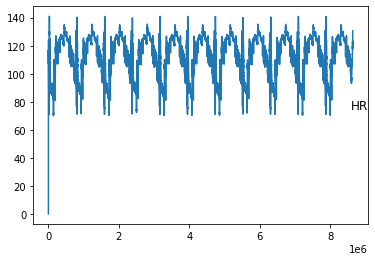

In [ ]:
# plot data
dataset = case4_filteredData # use if google drive
values = dataset.values

# specify columns to plot
groups = [0]
i =1
for g in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, g])
  plt.title(dataset.columns[g], y=0.5, loc='right')
  i += 1
# plt.show()

In [ ]:
# ----------------------------------------------------------------- MANUALLY RESAMPLE -------------------------------------------------------------------
def downsample_data(window):
  df_temp = pd.DataFrame(columns=['HR'])
  HR_sum = 0
  SPO_sum = 0
  NBP_sum = 0
  ECG_sum = 0

  for i in range(1, len(values) - 1):
    HR_sum += values[i, 0]
    if (i + 1) % window == 0:
      HR_sum = HR_sum/window
    
      row = {'HR':HR_sum}
      df_temp = df_temp.append(row, ignore_index = True)
      HR_sum = 0
      SPO_sum = 0
      NBP_sum = 0
      ECG_sum = 0
  return df_temp

old_data = case4_filteredData
print('Size of old data:')
print(old_data.shape)

# downsampling data
case4_filteredData = downsample_data(100)

print('Size of new data:')
print(case4_filteredData.shape)

Size of old data:
(8644384, 1)
Size of new data:
(86443, 1)


## Functions

In [ ]:
# FUNCTIONS
"""
This functions splits the data into training and test sets.

@param data_df : a Pandas Dataframe that contains the data to be split into training and test sets
@param train_size : a double/float that is within the range of 0 and 1 and represents the fraction of the data to be used for the training set

@returns two Numpy arrays that represent the training and test sets, respectively
"""
def split_data_train_test(data_df, train_size):
  train_df, test_df = data_df[0:round(train_size * len(data_df)), :], data_df[round(train_size * len(data_df)):len(data_df), :]

  return train_df, test_df



"""
This function takes in the data to be scaled and uses Min-Max Scaling.

@param data : a Numpy array that represents the inputted data to be scaled

@returns the scaled data as a Numpy array, the MinMax scaler object, the scaling factor used, and the minimum value of the original inputted data
"""
def minMaxScaling(data):
  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0.1, 1))
  scaler.fit(data)

  scaleFactor = scaler.scale_
  data_min = scaler.data_min_
  data_max = scaler.data_max_
  data = scaler.transform(data)

  return data, scaler, scaleFactor, data_min, data_max


"""
This function plots the inputted data in a 2D scatterplot.

@param xvals : a 1D Numpy array that contains the data to be plotted on the x-axis
@param data : a 1D Numpy array that contains the data to be plotted on the y-axis
@param xVariable : a string that represents the label of the data to be plotted for x-axis
@param yVariable : a string that represents the label of the data to be plotted for y-axis
"""
def plot_data(xvals, data, xVariable, yVariable):
  plt.figure(figsize=(10, 5))
  plt.scatter(xvals, data)
  plt.title("Plot of Data for " + yVariable + ", " + xVariable)
  plt.ylabel(yVariable)
  plt.xlabel(xVariable)
  plt.show()


"""
This function plots a loss function based on the output of the model fitting.

@param loss_vals : a Tensorflow History object from model fitting, which is used to get the training and validation loss values
@param startRange : an integer that is >= 0, is within the indices of loss_vals, and represents the start indices of the loss values to plot
@param endRange : an integer that is <= len(loss_vals) - 1, is larger than startRange, and represents the end indices of the loss values to plot
"""
def plot_loss(loss_vals, startRange, endRange):
  plt.figure(figsize=(12, 8))
  plt.plot(loss_vals.history['loss'][startRange:endRange], label="Training Loss") 
  plt.plot(loss_vals.history['val_loss'][startRange:endRange], label="Validation Loss") 
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.title("Learning Curve")
  plt.legend()


"""
This function plots the inputted actual and predicted data in a 2D scatterplot.

@param xvals : a 1D Numpy array that contains the data to be plotted on the x-axis
@param actual_data : a 1D Numpy array that contains the actual data to be plotted on the y-axis
@param predicted_data : a 1D Numpy array that contains the predicted data to be plotted on the y-axis
@param xName : a string that represents the x-values and label for the x-axis
@param yName : a string that represents the y-values and label for the y-axis
"""
def plot_model_data(xvals, actual_data, predicted_data, xName, yName):
  plt.figure(figsize=(12, 8))
  plt.scatter(xvals, actual_data, label="Actual Data", color="r")
  plt.plot(xvals, predicted_data, label="Predicted Data", color="black")
  plt.title("Plot of Model Data for " + xName + " Against " + yName)
  plt.xlabel(xName)
  plt.ylabel(yName)
  plt.legend()



"""
This function plots the inputted actual and predicted data in a 3D scatterplot.

@param x_val : a 1D Numpy array that contains the data to be plotted on the x-axis
@param y_val : a 1D Numpy array that contains the data to be plotted on the y-axis
@param actual_data : a 1D Numpy array that contains the actual data to be plotted on the z-axis
@param predicted_data : a 1D Numpy array that contains the predicted data to be plotted on the z-axis
@param xName : a string that represents the x-values and label for the x-axis
@param yName : a string that represents the y-values and label for the y-axis
@param zName : a string that represents the z-values and label for the z-axis
"""
def plot_model_data3D(x_val, y_val, actual_data, predicted_data, xName, yName, zName):
  fig = plt.figure(figsize=(12, 8))

  ax = plt.axes(projection='3d')
  ax.scatter3D(x_val, y_val, actual_data, label='Actual Data', color="red")
  ax.plot3D(x_val, y_val, predicted_data, label='Predicted Data', color="black")

  ax.set_title("Plot of Model Data for " + xName + " And " + yName + " Against " + zName, pad=20)
  ax.set_xlabel(xName)
  ax.set_ylabel(yName)
  ax.set_zlabel(zName)
  ax.legend()


"""
This functions gets and prints the root mean squared error (RMSE) of the targets.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the RMSE double/float value

MANUAL RMSE 
"""
def get_and_print_rmse_for_model(test_targets, predicted_targets):
  mse = sklearn.metrics.mean_squared_error(y_true=test_targets, y_pred=predicted_targets)  
  rmse = math.sqrt(mse)  
  print("RMSE: ", rmse)  
  
  return rmse 
"""
to calculate RMSE manually to add:
"""

#def calculate_rmse_manual(test_targets, predicted_targets):
  
"""
This functions gets and prints the coefficient of determination (R^2) of the targets.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the R^2 double/float value
"""

def get_and_print_R2_for_model(test_targets, predicted_targets):
    r2 = sklearn.metrics.r2_score(y_true=test_targets, y_pred=predicted_targets)
    print("R2 (Sklearn): " + str(r2))
  
    return r2



"""
This function uses the mean absolute percentage error (MAPE) to get a percentage error for a regression model. 

Note that if the output is a number above 1 or below 0, usually very big in magnitude, it is because 
some of the numbers in the test_targets are 0 or very close to 0, which gives a division by 0.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the MAPE double/float value which represents the decimal form of the percentage, so generally between 0 and 1
"""

def get_and_print_mape_for_model(test_targets, predicted_targets):
  mape = sklearn.metrics.mean_absolute_percentage_error(test_targets, predicted_targets)
  print("MAPE: " + str(mape))

  return mape



"""
This function gets the mean absolute error (MAE) for a regression model. 

Note that if the output is a number below 0, usually very big in magnitude, it is because 
some of the numbers in the test_targets are 0 or very close to 0, which gives a division by 0.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the MAPE double/float value, which should be greater than or equal to 0
"""
def get_and_print_mae_for_model(test_targets, predicted_targets):
  mae = sklearn.metrics.mean_absolute_error(test_targets, predicted_targets)
  print("MAE: " + str(mae))

  return mae



"""
This functions plots the actual and predicted values as a line plot.

@param indices : the x-values of the plot as a 1-column Numpy array
@param test_targets : a 1-column Numpy array that represents the actual target values
@param predicted_targets : a 1-column Numpy array that represents the predicted target values
"""
def plot_actual_and_predictions_line(x_val, test_targets, predicted_targets):
  # fig = plt.figure(figsize=(12, 8))
  # fig2 = plt.figure(figsize=(12, 8))
  
  # HR
  fig = plt.figure(figsize=(12, 8))
  plt.plot(x_val, test_targets[:, 0], label="Actual HR", c="b", linestyle="dashed")
  plt.plot(x_val, predicted_targets[:, 0], label="Predicted HR", c="lightblue", linestyle="dashed")
  plt.ylabel("HR Values")
  plt.title("Plot of Actual and Predicted Values - HR")
  plt.legend()

  # # SPO2
  # fig2 = plt.figure(figsize=(12, 8))
  # plt.plot(x_val, test_targets[:, 1], label="Actual SPO2", c="purple")
  # plt.plot(x_val, predicted_targets[:, 1], label="Predicted SPO2", c="lavender")
  # plt.ylabel("SPO2 Values")
  # plt.title("Plot of Actual and Predicted Values - SPO2")
  # plt.legend()

  # # NBP
  # fig3 = plt.figure(figsize=(12, 8))
  # plt.plot(x_val, test_targets[:, 2], label="Actual NBP", c="g")
  # plt.plot(x_val, predicted_targets[:, 2], label="Predicted NBP", c="lightgreen")
  # plt.ylabel("NBP Values")
  # plt.title("Plot of Actual and Predicted Values - NBP")
  # plt.legend()

  # # ECG
  # fig4 = plt.figure(figsize=(12, 8))
  # plt.plot(x_val, test_targets[:, 3], label="Actual ECG", c="r")
  # plt.plot(x_val, predicted_targets[:, 3], label="Predicted ECG", c="pink")
  # plt.ylabel("ECG Values")
  # plt.title("Plot of Actual and Predicted Values - ECG")
  # plt.legend()

  # plt.ylabel("Values")
  # plt.title("Plot of Actual and Predicted Values")
  # plt.legend()
  plt.show()



"""
This functions plots the actual and predicted values as a scatter plot.

@param indices : a 1-column Numpy array that represents x-values of the plot 
@param test_targets : a 1-column Numpy array that represents the actual target values
@param predicted_targets : a 1-column Numpy array that represents the predicted target values
"""
def plot_actual_and_predictions_scatter(x_val, test_targets, predicted_targets):
  fig = plt.figure(figsize=(12, 8))
  plt.scatter(x_val, test_targets, label="Actual Values", c="b")
  plt.scatter(x_val, predicted_targets, label="Predicted Values", c="r")

  plt.ylabel("Value")
  plt.title("Plot of Actual and Predicted Values")
  plt.legend()



"""
This function makes a custom artificial neural network model.

@param train_features : a Numpy array that represents the training data features
@param train_labels : a Numpy array that represents the training data targets
@param numOfUnits : a list that contains the number of units for each layer, which could be customized by providing different integers in the desired order. 
                    The size of the list should either be equal to 1 or numOfLayers. If size = 1, then all layers will have that number of units in the list.
                    (eg. [4, 8, 16] if numOfLayers = 3, or [4] for any value of numOfLayers)
@param numOfLayers : an integer that represents the desired of layers to add to the model 
@param epochNum : the number of iterations/epochs for running the model
@param learning_rate : a double/float that represents the learning rate of the model

@returns the artificial neural network TensorFlow model and the result from fitting the model

"""
def make_custom_ANN(train_features, train_labels, numOfUnits=[4], numOfLayers=3, batchNum=None, epochNum=100, learning_rate=0.01, min_delta=0.0007):
  callback_valLoss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=min_delta, mode='min', verbose=1)
  callback_trainLoss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1, min_delta=min_delta, mode='min', verbose=1)

  # ann_model = tf.keras.Sequential()
  limit = numOfLayers

  if (len(numOfUnits) is not numOfLayers) and (len(numOfUnits) is not 1):
    raise Exception("Invalid input for numOfUnits.")
  
  for i in range(0, limit):
    if len(numOfUnits) is numOfLayers:
      numUnits = numOfUnits[i]
    
    else:
      numUnits = numOfUnits[0]
  
  ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1),
    tf.keras.layers.Convolution1D(64, 3, activation='relu'), #add convolutional layer (filters, kernel size) 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(1) # default activation is linear 
    ])

  ann_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                    loss='mean_squared_error', metrics=['accuracy'])
  
  ann_model_fit = ann_model.fit(train_features, train_labels, batch_size=batchNum, epochs=epochNum, validation_split=0.3, callbacks=[callback_valLoss, callback_trainLoss])
  

  return ann_model, ann_model_fit


"""
This function splits the training and test sets and turns a certain number of previous values as "features" and the next value as the "target"

@param train_array : a Numpy array with at least 2 columns of the training set values
@param test_array : a Numpy array with at least 2 columns of the test set values
@param numOfPrevValues : an integer that represents the number of previous rows of values to use as features
@param targetIndex : an integer that represents the column number to use for target values

@returns four Numpy arrays for the previous values in the training set, the next 1 value in the training set, the previous values
         in the test set, and the next 1 value in the test set
"""
def splitDataToFeaturesTargetValues(train_array, test_array, numOfPrevValues=3, targetIndex=1):

  # prevData - features
  # nextData - labels

  prevData_train = []
  nextData_train = [] 
  prevData_test = []
  nextData_test = []

  for i in range(numOfPrevValues, len(train_array)):
    prevData_train.append(train_array[i-numOfPrevValues: i]) # append features as it's appending alls rows
    nextData_train.append(train_array[i]) # append label as it's only the row at the target colun

  # don't want to split test data this way
  for j in range(numOfPrevValues, len(test_array)):
    prevData_test.append(test_array[j-numOfPrevValues: j])
    nextData_test.append(test_array[j])  

  prevData_train = np.array(prevData_train)
  nextData_train = np.array(nextData_train).reshape(len(nextData_train), 1)
  print("TRAIN")
  print(f"This is shape of train features array: {prevData_train.shape}")
  print(f"This is shape of train labels array: {nextData_train.shape}")

  prevData_test = np.array(prevData_test)
  nextData_test = np.array(nextData_test).reshape(len(nextData_test), 1) # used to be 1d array w many columns but one row, now it's many rows 1 column so it's a 2d array i think
  print("TEST")
  print(f"This is shape of test features array: {prevData_test.shape}")
  print(f"This is shape of test labels array: {nextData_test.shape}")

  return prevData_train, nextData_train, prevData_test, nextData_test


<>:283: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:283: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-7-e343aa9b8363>:283: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (len(numOfUnits) is not numOfLayers) and (len(numOfUnits) is not 1):


## Model Stuff

In [ ]:
# Scaling and splitting dataset, using R-Wave Voltages and SpO2 as features
# pd.set_option("max_rows", 1000)
print(case4_filteredData.head(20))

case4_filteredData_arr_scaled, minMaxScaler, minMaxScaleFactor, case4_filteredData_min, case4_filteredData_max = minMaxScaling(case4_filteredData)
print("case 4 max: "), print(case4_filteredData_max)
print("case 4 min: "), print(case4_filteredData_min)

# Add more columns names if more health variables are added.
case4_filteredData_scaled = pd.DataFrame(case4_filteredData_arr_scaled, columns=["HR"])

# print()
# print(case4_filteredData_scaled[0:20])

listOfVariables = ["HR"] # Add more columns names if more health variables are added.
listOfVariables_len = len(listOfVariables) - 1 

data_train, data_test = split_data_train_test(np.array(case4_filteredData_scaled[listOfVariables]), train_size=0.8) # scaled data

print("\nOriginal data train: ")
print(data_train[0:20])

print(" Original test")
print(data_test[0:20])

print(" Here to see the size of each data: ")
print("This is the size of the train data: ")
print(data_train.shape)
print("This is the size of the test data: ")
print(data_test.shape)

        HR
0   110.88
1   113.92
2   114.94
3   115.91
4   116.89
5   116.13
6   116.00
7   115.18
8   114.21
9   114.00
10  114.00
11  114.00
12  114.70
13  115.00
14  114.35
15  114.00
16  113.40
17  112.42
18  110.88
19  109.47
case 4 max: 
[141.]
case 4 min: 
[70.]

Original data train: 
[[0.61819718]
 [0.65673239]
 [0.66966197]
 [0.68195775]
 [0.69438028]
 [0.68474648]
 [0.68309859]
 [0.67270423]
 [0.66040845]
 [0.65774648]
 [0.65774648]
 [0.65774648]
 [0.66661972]
 [0.67042254]
 [0.6621831 ]
 [0.65774648]
 [0.65014085]
 [0.63771831]
 [0.61819718]
 [0.60032394]]
 Original test
[[0.65992276]
 [0.65994948]
 [0.65972248]
 [0.64732625]
 [0.64735233]
 [0.65967395]
 [0.66007984]
 [0.6601052 ]
 [0.67153876]
 [0.67283122]
 [0.6728558 ]
 [0.67288011]
 [0.67290414]
 [0.67292787]
 [0.67295132]
 [0.67297445]
 [0.67299728]
 [0.6730198 ]
 [0.67304198]
 [0.67306384]]
 Here to see the size of each data: 
This is the size of the train data: 
(69154, 1)
This is the size of the test data: 
(17289, 1

##Artificial Neural Network Model for Using HR, SpO2, NBP (Mean), ECG to Predict HR

TRAIN
This is shape of train features array: (68154, 1000, 1)
This is shape of train labels array: (68154, 1)
TEST
This is shape of test features array: (16289, 1000, 1)
This is shape of test labels array: (16289, 1)
Epoch 1/5000
1491/1491 [==============================] - 510s 341ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 2/5000
1491/1491 [==============================] - 511s 343ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 3/5000
1491/1491 [==============================] - 510s 342ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 9.5942e-04 - val_accuracy: 0.0000e+00
Epoch 4/5000
1491/1491 [==============================] - 511s 343ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 9.0307e-04 - val_accuracy: 0.0000e+00
Epoch 4: early stopping
Model: "sequential"
_________________________________________________________________
 Layer (type)                Outp

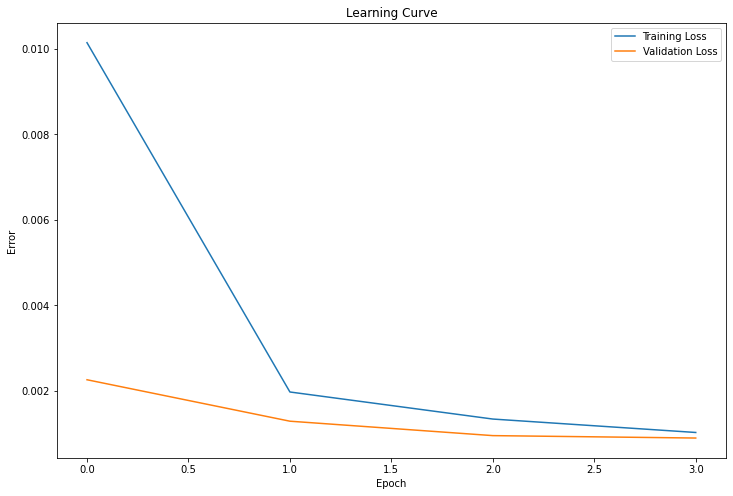

In [ ]:
# Running the model for HR - artificial neural network

data_train_features, data_train_label, data_test_features, data_test_label = splitDataToFeaturesTargetValues(data_train, data_test, numOfPrevValues=1000)

# batch_num = int(len(data_train_label) / 1350)
batch_num = None
epochNum = 5000
learn_rate = 0.000001
numOfUnits_list = [512]

ann_model_hr, ann_model_hr_fit = make_custom_ANN(data_train_features, data_train_label, numOfUnits=numOfUnits_list, batchNum=batch_num,
                                           numOfLayers=3, epochNum=epochNum, learning_rate=learn_rate, min_delta=0.0001)

plot_loss(ann_model_hr_fit, 0, epochNum)
ann_model_hr.summary()

In [ ]:
print(data_train_features.shape) # input shape into predictions
print(data_test_features.shape)
print(data_test_features)
print(data_test_label)
# print("This is the test predictions",all_values)

(68154, 1000, 1)
(16289, 1000, 1)
[[[0.65992276]
  [0.65994948]
  [0.65972248]
  ...
  [0.50051094]
  [0.50406746]
  [0.50407478]]

 [[0.65994948]
  [0.65972248]
  [0.64732625]
  ...
  [0.50406746]
  [0.50407478]
  [0.50408221]]

 [[0.65972248]
  [0.64732625]
  [0.64735233]
  ...
  [0.50407478]
  [0.50408221]
  [0.50408975]]

 ...

 [[0.62103407]
  [0.62952683]
  [0.63370949]
  ...
  [0.8680863 ]
  [0.86812517]
  [0.8681645 ]]

 [[0.62952683]
  [0.63370949]
  [0.64156796]
  ...
  [0.86812517]
  [0.8681645 ]
  [0.86820428]]

 [[0.63370949]
  [0.64156796]
  [0.64638392]
  ...
  [0.8681645 ]
  [0.86820428]
  [0.86824452]]]
[[0.50408221]
 [0.50408975]
 [0.5040974 ]
 ...
 [0.86820428]
 [0.86824452]
 [0.86828521]]



For training set:

2130/2130 [==============================] - 151s 71ms/step
Shape of predictions BEFORE reshape: 
(68154, 1)
[[0.3589976 ]
 [0.35873908]
 [0.3579944 ]
 ...
 [0.65946025]
 [0.66306967]
 [0.66422933]]
RMSE:  0.031176949282109144
R2 (Sklearn): 0.9687479299408869
MAE: 0.02025448776314088
MAPE: 0.03709705314974156


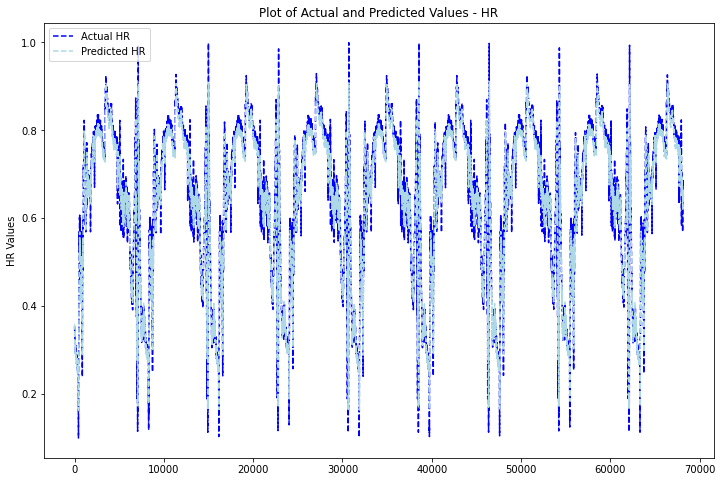


After reversing the scaling:

RMSE:  2.45951493859628
R2 (Sklearn): 0.9687479286502662
MAE: 1.597854193418637
MAPE: 0.014470513844633085


0.014470513844633085

In [ ]:
# Predicting with the model for HR - training set - ANN

# making the predictions  -------------------------------------------------------------------------------------
print("\nFor training set:\n")
predictions = ann_model_hr.predict(data_train_features)
print("Shape of predictions BEFORE reshape: "), print(predictions.shape)
print(predictions)

# reshape into 2d array? into the shape of the train features which is 3d
# predictions = predictions.reshape(data_train_features.shape[0], data_train_features.shape[1], data_train_features.shape[2]) # current shape is (length, numOfPrevValues, 1) - new shape (length, numOfPrevValues, 4)
# predictions = predictions[:, 0] # getting values for the next time step (t) and not (t+1, t+2, or t+3)
# predictions = np.reshape(predictions, newshape=(len(predictions), 1))

# plotting accuracies and losses -------------------------------------------------------------------------------
get_and_print_rmse_for_model(data_train_label, predictions)
get_and_print_R2_for_model(data_train_label, predictions)
get_and_print_mae_for_model(data_train_label, predictions)
get_and_print_mape_for_model(data_train_label, predictions)

plot_actual_and_predictions_line(np.arange(0, len(data_train_label)), data_train_label, predictions)
# plot_actual_and_predictions_scatter(np.arange(0, len(data_train_label)), data_train_label, predictions)

print("\nAfter reversing the scaling:\n")

# For if MinMaxScaler was used; change the column number/index to get the values for other health variables
predictions_reversed = ((predictions - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_min[0]) + case4_filteredData_min[0]
data_train_label_reversed = ((data_train_label - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_min[0]) + case4_filteredData_min[0]
# data_train_features_reversed = ((data_train_features - 0.1) / (1 - 0.1)) * (combinedData_max[0] - combinedData_min[0]) + combinedData_min[0]

# For if standard scaling was used; change the column number/index to get the values for other health variables
# predictions_reversed = predictions * combinedData_stdDev[1] + combinedData_mean[1]
# data_train_label_reversed = data_train_label * combinedData_stdDev[1] + combinedData_mean[1]
# data_train_features_reversed = data_train_features * combinedData_stdDev[0] + combinedData_mean[0]

get_and_print_rmse_for_model(data_train_label_reversed, predictions_reversed)
get_and_print_R2_for_model(data_train_label_reversed, predictions_reversed)
get_and_print_mae_for_model(data_train_label_reversed, predictions_reversed)
get_and_print_mape_for_model(data_train_label_reversed, predictions_reversed)


In [ ]:
# Predicting with the model for HR - test set - ANN ---------------- NEW METHOD

print("\nFor testing set:\n")

# set initial values
numOfPrevValues = 1000
batch = []
all_values = []

# ALL IMPLEMENTED INTO THE LOOP
for i in range(0, len(data_test_features) - numOfPrevValues):
  print(i)
  # 1. set the batch accordingly
  if i == 0:
    # only first batch comes from data_test features
    batch = data_test_features[0]
    all_values = batch
  else:
    batch = all_values[i:]

  # 2. reshape the batch
  # old shape (2d) - (27,4)
  # new shape (3d) - (1,27,4) - need to be 3d because shape of model input is also 3d 
  batch = batch.reshape(1, data_test_features[0].shape[0], data_test_features[0].shape[1])

  # 3. make the prediction
  predicted_val = ann_model_hr.predict(batch)
  # revert reshaping to 2d
  batch = batch.reshape(data_test_features[0].shape[0], data_test_features[0].shape[1])

  # 4. append to all values array
  # all_values = batch
  all_values = np.append(all_values, [predicted_val[0]], axis=0)
  all_values = np.array(all_values)

  # 5. print everything
  print(f"LOOP #{i}:")
  print(f"Batch {i} shape: {batch.shape}")
  # print(batch)
  print(f"Predicted {i} shape: {predicted_val.shape}")
  # print(predicted_val)
  print(f"All predicted values shape: {all_values.shape}")
  # print(all_values)


In [ ]:
# Predicting with the model for HR - test set - ANN - OLD METHOD DON'T USE

# print("\nFor testing set:\n")

# predictions = ann_model_hr.predict(data_test_features)

# predictions = predictions.reshape(data_test_features.shape[0], data_test_features.shape[1]) # current shape is (length, numOfPrevValues, 1)
# predictions = predictions[:, 0] # getting values for the next time step (t) and not (t+1, t+2, or t+3)
# predictions = np.reshape(predictions, newshape=(len(predictions), 1))
# predictions[predictions > 1.0] = 1.0

get_and_print_rmse_for_model(data_test_label, all_values)
get_and_print_R2_for_model(data_test_label, all_values)
get_and_print_mae_for_model(data_test_label, all_values)
get_and_print_mape_for_model(data_test_label, all_values)

plot_actual_and_predictions_line(np.arange(0, len(data_test_label)), data_test_label, all_values)
# plot_actual_and_predictions_scatter(np.arange(0, len(data_test_label)), data_test_label, all_values)

# # this function won't plot properly if there are more than 3 variables in the model
# plot_model_data3D(data_test_features[:, :, 0][:, 0].flatten(), data_test_features[:, :, 2][:, 0].flatten(), data_test_features[:, :, 1][:, 0].flatten(),
#                  predictions.flatten(), "R-Wave Voltages", "SpO2", "HR") 

# column 1 for HR values, 0 for ECG R-Wave Voltages
print("\nAfter reversing the scaling: \n")

# For if MinMaxScaler was used; change the column number/index to get the values for other health variables
predictions_reversed = ((all_values - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_max[0]) + case4_filteredData_max[0]
data_test_label_reversed = ((data_test_label - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_max[0]) + case4_filteredData_max[0]
# data_test_features_reversed = ((data_test_features - 0.1) / (1 - 0.1)) * (combinedData_max[0] - combinedData_min[0]) + combinedData_min[0]
# predictions_reversed[predictions_reversed > 100] = 100

# For if standard scaling was used; change the column number/index to get the values for other health variables
# predictions_reversed = predictions * combinedData_stdDev[1] + combinedData_mean[1]
# data_test_label_reversed = data_test_label * combinedData_stdDev[1] + combinedData_mean[1]
# data_test_features_reversed = data_test_features * combinedData_stdDev[0] + combinedData_mean[0]

get_and_print_rmse_for_model(data_test_label_reversed, predictions_reversed)
get_and_print_R2_for_model(data_test_label_reversed, predictions_reversed)
get_and_print_mae_for_model(data_test_label_reversed, predictions_reversed)
get_and_print_mape_for_model(data_test_label_reversed, predictions_reversed)

#plotting results 


In [ ]:
#Plotting results

#HR
fig = plt.figure(figsize=(12, 8))
xtrain_set = np.arange(0, len(data_train_features))
ytrain_set = np.array(data_train_label[:,0])
plt.plot(xtrain_set, ytrain_set, 'b', label="Actual Train")

xtest_set = np.arange(len(data_train_features),len(data_train_features) + len(data_test_features))
ytest_set = np.array(data_test_label[:,0])
plt.plot(xtest_set, ytest_set, 'r', label="Actual Test")

pred_train_sig = np.array(predictions[:,0])
plt.plot(xtrain_set, pred_train_sig, 'orange', label="Predicted Train", linestyle="dotted")

pred_test_sig = np.array(all_values[:,0])
plt.plot(xtest_set, pred_test_sig,'green', label="Predicted Test", linestyle="dotted")
plt.title("Heart Rate (HR)")
plt.legend()
plt.show()



# #SpO2
# fig = plt.figure(figsize=(12, 8))
# xtrain_set = np.arange(0, len(data_train_features))
# ytrain_set = np.array(data_train_label[:,1])
# plt.plot(xtrain_set, ytrain_set, 'b', label="Actual Train")

# xtest_set = np.arange(len(data_train_features),len(data_train_features) + len(data_test_features))
# ytest_set = np.array(data_test_label[:,1])
# plt.plot(xtest_set, ytest_set, 'r', label="Actual Test")

# pred_train_sig = np.array(predictions[:,1])
# plt.plot(xtrain_set, pred_train_sig, 'orange', label="Predicted Train", linestyle="dotted")

# pred_test_sig = np.array(all_values[:,1])
# plt.plot(xtest_set, pred_test_sig,'green', label="Predicted Test", linestyle="dotted")
# plt.title("SpO2")
# plt.legend()
# plt.show()





# #NBP
# fig = plt.figure(figsize=(12, 8))
# xtrain_set = np.arange(0, len(data_train_features))
# ytrain_set = np.array(data_train_label[:,2])
# plt.plot(xtrain_set, ytrain_set, 'b', label="Actual Train")

# xtest_set = np.arange(len(data_train_features),len(data_train_features) + len(data_test_features))
# ytest_set = np.array(data_test_label[:,2])
# plt.plot(xtest_set, ytest_set, 'r', label="Actual Test")

# pred_train_sig = np.array(predictions[:,2])
# plt.plot(xtrain_set, pred_train_sig, 'orange', label="Predicted Train", linestyle="dotted")

# pred_test_sig = np.array(all_values[:,2])
# plt.plot(xtest_set, pred_test_sig,'green', label="Predicted Test", linestyle="dotted")
# plt.title("NBP")
# plt.legend()
# plt.show()





# #ECG
# fig = plt.figure(figsize=(12, 8))
# xtrain_set = np.arange(0, len(data_train_features))
# ytrain_set = np.array(data_train_label[:,3])
# plt.plot(xtrain_set, ytrain_set, 'b', label="Actual Train")

# xtest_set = np.arange(len(data_train_features),len(data_train_features) + len(data_test_features))
# ytest_set = np.array(data_test_label[:,3])
# plt.plot(xtest_set, ytest_set, 'r', label="Actual Test")

# pred_train_sig = np.array(predictions[:,3])
# plt.plot(xtrain_set, pred_train_sig, 'orange', label="Predicted Train", linestyle="dotted")

# pred_test_sig = np.array(all_values[:,3])
# plt.plot(xtest_set, pred_test_sig,'green', label="Predicted Test", linestyle="dotted")
# plt.title("ECG")
# plt.legend()
# plt.show()